# Analysis of $\Delta$G and $\Delta\Delta$G of 11ntR$\cdot$GAAA variants compared to the wild type.
Copyright 2023 John Shin under GPL-3.0

Figures 1B, 2B and C, 4, and 5C and D come from this document.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
# from matplotlib.transforms import Bbox
import matplotlib.markers as mmarkers
from matplotlib.gridspec import GridSpec
import seaborn as sns

from tqdm import tqdm
import re

import networkx as nx

from statsmodels.stats import multitest

In [2]:
def displayAllRows(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('max_rows')
    
def displayAllCols(df):
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('max_columns')
    
def displayAllIndex(df):
    pd.set_option('display.multi_sparse', False)
    display(df)
    pd.reset_option('display.multi_sparse')
    
    
def revDict(d):
    return {v: k for k, v in d.items()}

In [3]:
def subtractWt(df,wt_df):
    '''subtracts the wt_df from df by scaffold'''
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    
    sub_df = df.copy()
    sub_df[bs_cols] = np.subtract(sub_df[bs_cols],np.tile(wt_df[bs_cols],(len(sub_df)//5,1)))
    
    return sub_df

In [4]:
def subtractdfs(df1,df2):
    '''subtracts df2 from df1 by index'''
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    
    sub_df = df1.copy()
    sub_df[bs_cols] = np.subtract(sub_df[bs_cols],df2[bs_cols])
    
    return sub_df

In [5]:
def findPercentiles(df,p=[0.5,0.025,0.975],p_names=['dG','dG_lb','dG_ub']):
    '''extracts the p percentile value from bs df'''
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    
    out_df = pd.DataFrame(index=df.index)
    out_df[p_names] = df[bs_cols].quantile(q=p,axis=1).T
    
    return out_df

In [6]:
def replaceLimits(df,limits):
    
    out_df = df.copy()
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
       
    out_df.loc[limits[limits].index,bs_cols] = -7.1
    
    return out_df

In [7]:
def findPercentilesOverScaffolds(df,p=[0.5,0.025,0.975],p_names=['dG','dG_lb','dG_ub']):
    '''extracts the p percentile value from bs df'''
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    
    out_df = pd.DataFrame(index=df.index.levels[0])
    
    g = df[bs_cols].groupby(
        'seq').agg(
        np.nanmean).quantile(
        q=p,axis=1).T.rename(
        columns={k:v for k,v in zip(p,p_names)})
    
    out_df = out_df.join(g)
    
    return out_df

In [8]:
def adj_pvals(df,p_col='p_val',a_col='adj_p_val',method='fdr_bh'):
    
    out_df = df.copy()
    temp_pvals = out_df[p_col]
    temp_corr_pvals = temp_pvals.copy()
    _,temp_corr_pvals[~np.isnan(temp_pvals)],_,_ = multitest.multipletests(
        temp_pvals[~np.isnan(temp_pvals)],method=method)
    out_df[a_col] = temp_corr_pvals
    
    return out_df

In [9]:
nuc_palette = {'A':'tab:blue',
               'U':'tab:orange',
               'G':'tab:green',
               'C':'tab:red'}

# Import Data

Import data with all the bootstrapped info

In [10]:
data_path = 'Data/'

In [11]:
GAAA_wt_bs_df = pd.read_pickle(data_path+'GAAA_wt_df.pkl')
GAAA_single_bs_df = pd.read_pickle(data_path+'GAAA_single_df.pkl')
GAAA_double_bs_df = pd.read_pickle(data_path+'GAAA_double_df.pkl')
GAAA_double_bs_df.index.names = ['seq','scaffold']

In [12]:
GUAA_wt_bs_df = pd.read_pickle(data_path+'GUAA_wt_df.pkl')
GUAA_single_bs_df = pd.read_pickle(data_path+'GUAA_single_df.pkl')
GUAA_double_bs_df = pd.read_pickle(data_path+'GUAA_double_df.pkl')
GUAA_double_bs_df.index.names = ['seq','scaffold']

Define global variables and import metadata for variants

In [13]:
sequence_11ntRwt = GUAA_wt_bs_df.index[0][0]
mutation_dict_11ntR = {
    0:7, 1:8, 2:9, 3:10, 4:11, 5:1, 6:2, 7:3, 8:4, 9:5, 10:6, 
}
layout_11ntR = {
    1:[5,10],
    2:[6,8],
    3:[5.5,6],
    4:[3,4],
    5:[6,4],
    6:[5,2],
    7:[2,2],
    8:[2.5,6],
    9:[1,7],
    10:[3,8],
    11:[2,10]
}
base_pairs_11ntR = [[11,1],[10,2],[9,0],[8,3],[4,5],[7,6]]
base_pair_plot_dict = {
    1:1,11:1,
    2:2,10:2,
    9:3,
    3:4,8:4,
    4:5,5:5,
    6:6,7:6
}
base_step = {
    11:8,
    1:8,
    10:6,
    2:6,
    9:5,
    8:4,
    3:4,
    4:2,
    5:2,
    7:0,
    6:0
}

In [14]:
# wt_meta_df = GAAA_wt_bs_df[[]].copy()
# single_meta_df = GAAA_single_bs_df[['first_loc','first_res','second_loc','second_res']].copy()
# double_meta_df = GAAA_double_bs_df[['first_loc','first_res','second_loc','second_res']].copy()

In [15]:
# wt_meta_df.to_pickle(data_path+'wt_meta.pkl')
# single_meta_df.to_pickle(data_path+'single_meta.pkl')
# double_meta_df.to_pickle(data_path+'double_meta.pkl')

Calculate $\Delta$G values (median and 95% CI), both separated by scaffold and averaged over scaffolds

In [16]:
# dG_GAAA_wt_df = findPercentiles(GAAA_wt_bs_df)
# dG_GAAA_single_df = pd.concat((single_meta_df,findPercentiles(GAAA_single_bs_df)),axis=1)
# dG_GAAA_double_df = pd.concat((double_meta_df,findPercentiles(GAAA_double_bs_df)),axis=1)

# dG_GUAA_wt_df = findPercentiles(GUAA_wt_bs_df)
# dG_GUAA_single_df = pd.concat((single_meta_df,findPercentiles(GUAA_single_bs_df)),axis=1)
# dG_GUAA_double_df = pd.concat((double_meta_df,findPercentiles(GUAA_double_bs_df)),axis=1)

# for df in [dG_GAAA_wt_df,dG_GAAA_single_df,dG_GAAA_double_df,
#            dG_GUAA_wt_df,dG_GUAA_single_df,dG_GUAA_double_df]:
#     df['limit'] = df['dG'] >= -7.1
#     df.loc[df['limit'],'dG'] = -7.1

In [17]:
# dG_GAAA_wt_df.to_pickle(data_path+'dGs/dG_GAAA_wt_df.pkl')
# dG_GAAA_single_df.to_pickle(data_path+'dGs/dG_GAAA_single_df.pkl')
# dG_GAAA_double_df.to_pickle(data_path+'dGs/dG_GAAA_double_df.pkl')

# dG_GUAA_wt_df.to_pickle(data_path+'dGs/dG_GUAA_wt_df.pkl')
# dG_GUAA_single_df.to_pickle(data_path+'dGs/dG_GUAA_single_df.pkl')
# dG_GUAA_double_df.to_pickle(data_path+'dGs/dG_GUAA_double_df.pkl')

In [18]:
dG_GAAA_wt_df = pd.read_pickle(data_path+'dGs/dG_GAAA_wt_df.pkl')
dG_GAAA_single_df = pd.read_pickle(data_path+'dGs/dG_GAAA_single_df.pkl')
dG_GAAA_double_df = pd.read_pickle(data_path+'dGs/dG_GAAA_double_df.pkl')

dG_GUAA_wt_df = pd.read_pickle(data_path+'dGs/dG_GUAA_wt_df.pkl')
dG_GUAA_single_df = pd.read_pickle(data_path+'dGs/dG_GUAA_single_df.pkl')
dG_GUAA_double_df = pd.read_pickle(data_path+'dGs/dG_GUAA_double_df.pkl')

In [19]:
GAAA_ddG_limit = -7.1 - np.mean(dG_GAAA_wt_df['dG'])
GUAA_ddG_limit = -7.1 - np.mean(dG_GUAA_wt_df['dG'])

In [20]:
# avg_dG_GAAA_wt_df = findPercentilesOverScaffolds(GAAA_wt_bs_df)

# avg_dG_GAAA_single_df = pd.concat((single_meta_df.groupby('seq').first(),
#                                 findPercentilesOverScaffolds(
#                                     replaceLimits(
#                                         GAAA_single_bs_df,
#                                         limits=dG_GAAA_single_df['limit']
#                                     )
#                                 )),axis=1)

# avg_dG_GAAA_double_df = pd.concat((double_meta_df.groupby('seq').first(),
#                                 findPercentilesOverScaffolds(
#                                     replaceLimits(
#                                         GAAA_double_bs_df,
#                                         limits=dG_GAAA_double_df['limit']
#                                     )
#                                 )),axis=1)

# avg_dG_GUAA_wt_df = findPercentilesOverScaffolds(GUAA_wt_bs_df)

# avg_dG_GUAA_single_df = pd.concat((single_meta_df.groupby('seq').first(),
#                                 findPercentilesOverScaffolds(
#                                     replaceLimits(
#                                         GUAA_single_bs_df,
#                                         limits=dG_GUAA_single_df['limit']
#                                     )
#                                 )),axis=1)

# avg_dG_GUAA_double_df = pd.concat((double_meta_df.groupby('seq').first(),
#                                 findPercentilesOverScaffolds(
#                                     replaceLimits(
#                                         GUAA_double_bs_df,
#                                         limits=dG_GUAA_double_df['limit']
#                                     )
#                                 )),axis=1)

# for df,avg_df in zip([dG_GAAA_single_df,dG_GAAA_double_df,
#                        dG_GUAA_single_df,dG_GUAA_double_df],
#                   [avg_dG_GAAA_single_df,avg_dG_GAAA_double_df
#                    ,avg_dG_GUAA_single_df,avg_dG_GUAA_double_df]):
#     avg_df['limit'] = df.groupby('seq')['limit'].any()

In [21]:
# avg_dG_GAAA_wt_df.to_pickle('data_path+dGs/avg_dG_GAAA_wt_df.pkl')
# avg_dG_GAAA_single_df.to_pickle(data_path+'dGs/avg_dG_GAAA_single_df.pkl')
# avg_dG_GAAA_double_df.to_pickle(data_path+'dGs/avg_dG_GAAA_double_df.pkl')
# avg_dG_GUAA_wt_df.to_pickle(data_path+'dGs/avg_dG_GUAA_wt_df.pkl')
# avg_dG_GUAA_single_df.to_pickle(data_path+'dGs/avg_dG_GUAA_single_df.pkl')
# avg_dG_GUAA_double_df.to_pickle(data_path+'dGs/avg_dG_GUAA_double_df.pkl')

In [22]:
avg_dG_GAAA_wt_df = pd.read_pickle(data_path+'dGs/avg_dG_GAAA_wt_df.pkl')
avg_dG_GAAA_single_df = pd.read_pickle(data_path+'dGs/avg_dG_GAAA_single_df.pkl')
avg_dG_GAAA_double_df = pd.read_pickle(data_path+'dGs/avg_dG_GAAA_double_df.pkl')
avg_dG_GUAA_wt_df = pd.read_pickle(data_path+'dGs/avg_dG_GUAA_wt_df.pkl')
avg_dG_GUAA_single_df = pd.read_pickle(data_path+'dGs/avg_dG_GUAA_single_df.pkl')
avg_dG_GUAA_double_df = pd.read_pickle(data_path+'dGs/avg_dG_GUAA_double_df.pkl')

Calculate $\Delta\Delta$G values (median and 95% CI) from wild type, both separated by scaffold and averaged over scaffolds

In [23]:
# ddG_GAAA_single_df = pd.concat((single_meta_df,
#                             findPercentiles(
#                                 subtractWt(
#                                     replaceLimits(
#                                         GAAA_single_bs_df,
#                                         limits=dG_GAAA_single_df['limit']
#                                     ),GAAA_wt_bs_df),
#                                p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)
# ddG_GAAA_double_df = pd.concat((double_meta_df,
#                             findPercentiles(
#                                 subtractWt(
#                                     replaceLimits(
#                                         GAAA_double_bs_df,
#                                         limits=dG_GAAA_double_df['limit']
#                                     ),GAAA_wt_bs_df),
#                             p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)

# ddG_GUAA_single_df = pd.concat((single_meta_df,
#                             findPercentiles(
#                                 subtractWt(
#                                     replaceLimits(
#                                         GUAA_single_bs_df,
#                                         limits=dG_GUAA_single_df['limit']
#                                     ),GUAA_wt_bs_df
#                                 ),
#                                 p_names=['ddG','ddG_lb','ddG_ub']),
#                             findPercentiles(
#                                 subtractWt(
#                                     replaceLimits(
#                                         GUAA_single_bs_df,
#                                         limits=dG_GUAA_single_df['limit']
#                                     ),GAAA_wt_bs_df
#                                 ),
#                                 p_names=['ddG_GAAA','ddG_GAAA_lb','ddG_GAAA_ub'])),axis=1)

# ddG_GUAA_double_df = pd.concat((double_meta_df,
#                             findPercentiles(
#                                 subtractWt(
#                                     replaceLimits(
#                                         GUAA_double_bs_df,
#                                         limits=dG_GUAA_double_df['limit']
#                                     ),GUAA_wt_bs_df
#                                 ),
#                                p_names=['ddG','ddG_lb','ddG_ub']),
#                             findPercentiles(
#                                 subtractWt(
#                                     replaceLimits(
#                                         GUAA_double_bs_df,
#                                         limits=dG_GUAA_double_df['limit']
#                                     ),GAAA_wt_bs_df
#                                 ),
#                                 p_names=['ddG_GAAA','ddG_GAAA_lb','ddG_GAAA_ub'])),axis=1)

# for df,ddf in zip([dG_GAAA_single_df,dG_GAAA_double_df,dG_GUAA_single_df,dG_GUAA_double_df],
#                   [ddG_GAAA_single_df,ddG_GAAA_double_df,ddG_GUAA_single_df,ddG_GUAA_double_df]):
#     ddf['limit'] = df['limit']

In [24]:
# ddG_GAAA_single_df.to_pickle(data_path+'ddGs/ddG_GAAA_single_df.pkl')
# ddG_GAAA_double_df.to_pickle(data_path+'ddGs/ddG_GAAA_double_df.pkl')
# ddG_GUAA_single_df.to_pickle(data_path+'ddGs/ddG_GUAA_single_df.pkl')
# ddG_GUAA_double_df.to_pickle(data_path+'ddGs/ddG_GUAA_double_df.pkl')

In [25]:
ddG_GAAA_single_df = pd.read_pickle(data_path+'ddGs/ddG_GAAA_single_df.pkl')
ddG_GAAA_double_df = pd.read_pickle(data_path+'ddGs/ddG_GAAA_double_df.pkl')
ddG_GUAA_single_df = pd.read_pickle(data_path+'ddGs/ddG_GUAA_single_df.pkl')
ddG_GUAA_double_df = pd.read_pickle(data_path+'ddGs/ddG_GUAA_double_df.pkl')

In [26]:
# avg_ddG_GAAA_single_df = pd.concat((single_meta_df.groupby('seq').first(),
#                         findPercentilesOverScaffolds(
#                             subtractWt(
#                                 replaceLimits(
#                                     GAAA_single_bs_df,
#                                     limits=dG_GAAA_single_df['limit']
#                                 ),GAAA_wt_bs_df
#                             ),
#                             p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)

# avg_ddG_GAAA_double_df = pd.concat((double_meta_df.groupby('seq').first(),
#                         findPercentilesOverScaffolds(
#                             subtractWt(
#                                 replaceLimits(
#                                     GAAA_double_bs_df,
#                                     limits=dG_GAAA_double_df['limit']
#                                 ),GAAA_wt_bs_df
#                             ),
#                             p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)

# avg_ddG_GUAA_single_df = pd.concat((single_meta_df.groupby('seq').first(),
#                         findPercentilesOverScaffolds(
#                             subtractWt(
#                                 replaceLimits(
#                                     GUAA_single_bs_df,
#                                     limits=dG_GUAA_single_df['limit']
#                                 ),GUAA_wt_bs_df
#                             ),
#                             p_names=['ddG','ddG_lb','ddG_ub']),
#                         findPercentilesOverScaffolds(
#                             subtractWt(
#                                 replaceLimits(
#                                     GUAA_single_bs_df,
#                                     limits=dG_GUAA_single_df['limit']
#                                 ),GAAA_wt_bs_df
#                             ),
#                             p_names=['ddG_GAAA','ddG_GAAA_lb','ddG_GAAA_ub'])),axis=1)

# avg_ddG_GUAA_double_df = pd.concat((double_meta_df.groupby('seq').first(),
#                         findPercentilesOverScaffolds(
#                             subtractWt(
#                                 replaceLimits(
#                                     GUAA_double_bs_df,
#                                     limits=dG_GUAA_double_df['limit']
#                                 ),GUAA_wt_bs_df
#                             ),
#                             p_names=['ddG','ddG_lb','ddG_ub']),
#                         findPercentilesOverScaffolds(
#                             subtractWt(
#                                 replaceLimits(
#                                     GUAA_double_bs_df,
#                                     limits=dG_GUAA_double_df['limit']
#                                 ),GAAA_wt_bs_df
#                             ),
#                             p_names=['ddG_GAAA','ddG_GAAA_lb','ddG_GAAA_ub'])),axis=1)

# for df,avg_ddf in zip([dG_GAAA_single_df,dG_GAAA_double_df,
#                        dG_GUAA_single_df,dG_GUAA_double_df],
#                   [avg_ddG_GAAA_single_df,avg_ddG_GAAA_double_df
#                    ,avg_ddG_GUAA_single_df,avg_ddG_GUAA_double_df]):
#     avg_ddf['limit'] = df.groupby('seq')['limit'].any()

In [27]:
# avg_ddG_GAAA_single_df.to_pickle(data_path+'ddGs/avg_ddG_GAAA_single_df.pkl')
# avg_ddG_GAAA_double_df.to_pickle(data_path+'ddGs/avg_ddG_GAAA_double_df.pkl')
# avg_ddG_GUAA_single_df.to_pickle(data_path+'ddGs/avg_ddG_GUAA_single_df.pkl')
# avg_ddG_GUAA_double_df.to_pickle(data_path+'ddGs/avg_ddG_GUAA_double_df.pkl')

In [28]:
avg_ddG_GAAA_single_df = pd.read_pickle(data_path+'ddGs/avg_ddG_GAAA_single_df.pkl')
avg_ddG_GAAA_double_df = pd.read_pickle(data_path+'ddGs/avg_ddG_GAAA_double_df.pkl')
avg_ddG_GUAA_single_df = pd.read_pickle(data_path+'ddGs/avg_ddG_GUAA_single_df.pkl')
avg_ddG_GUAA_double_df = pd.read_pickle(data_path+'ddGs/avg_ddG_GUAA_double_df.pkl')

In [29]:
# pd.concat([pd.DataFrame(columns=['first_loc','first_res','second_loc','second_res','ddG','ddG_lb','ddG_ub','limit'],
#              index=[sequence_11ntRwt]),
#            avg_ddG_GAAA_single_df,
#            avg_ddG_GAAA_double_df
#           ]).to_csv(data_path+'avg_ddG_GAAA.csv')

In [30]:
# pd.concat([pd.DataFrame(columns=['first_loc','first_res','second_loc','second_res','ddG','ddG_lb',
#                                    'ddG_ub','ddG_GAAA','ddG_GAAA_lb','ddG_GAAA_ub','limit'],
#              index=[sequence_11ntRwt]),
#            avg_ddG_GUAA_single_df,
#            avg_ddG_GUAA_double_df
#           ]).to_csv(data_path+'avg_ddG_GUAA.csv')


Calculate $\Delta\Delta$G values (median and 95% CI) between GUAA and GAAA for all variants

__Note: Supplemental Section__

In [31]:
# ddG_specificity_wt_df = pd.concat((wt_meta_df,
#                             findPercentiles(
#                                 subtractdfs(
#                                     replaceLimits(
#                                         GUAA_wt_bs_df,
#                                         limits=dG_GUAA_wt_df['limit']
#                                     ),
#                                     replaceLimits(
#                                         GAAA_wt_bs_df,
#                                         limits=dG_GAAA_wt_df['limit']
#                                     )),
#                                p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)

# ddG_specificity_single_df = pd.concat((single_meta_df,
#                             findPercentiles(
#                                 subtractdfs(
#                                     replaceLimits(
#                                         GUAA_single_bs_df,
#                                         limits=dG_GUAA_single_df['limit']
#                                     ),
#                                     replaceLimits(
#                                         GAAA_single_bs_df,
#                                         limits=dG_GAAA_single_df['limit']
#                                     )),
#                                p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)
# ddG_specificity_double_df = pd.concat((double_meta_df,
#                             findPercentiles(
#                                 subtractdfs(
#                                     replaceLimits(
#                                         GUAA_double_bs_df,
#                                         limits=dG_GUAA_double_df['limit']
#                                     ),
#                                     replaceLimits(
#                                         GAAA_double_bs_df,
#                                         limits=dG_GAAA_double_df['limit']
#                                     )),
#                                p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)

# for df1,df2,ddf in zip([dG_GAAA_single_df,dG_GAAA_double_df],
#                        [dG_GUAA_single_df,dG_GUAA_double_df],
#                        [ddG_specificity_single_df,ddG_specificity_double_df]):
#     ddf['limit'] = (df1['limit'])|(df2['limit'])
# ddG_specificity_wt_df['limit'] = False

In [32]:
# ddG_specificity_wt_df.to_pickle(data_path+'specificity/ddG_specificity_wt_df.pkl')
# ddG_specificity_single_df.to_pickle(data_path+'specificity/ddG_specificity_single_df.pkl')
# ddG_specificity_double_df.to_pickle(data_path+'specificity/ddG_specificity_double_df.pkl')

In [33]:
# ddG_specificity_wt_df = pd.read_pickle(data_path+'specificity/ddG_specificity_wt_df.pkl')
# ddG_specificity_single_df = pd.read_pickle(data_path+'specificity/ddG_specificity_single_df.pkl')
# ddG_specificity_double_df = pd.read_pickle(data_path+'specificity/ddG_specificity_double_df.pkl')

In [34]:
# avg_ddG_specificity_wt_df = pd.concat((wt_meta_df.groupby('seq').first(),
#                         findPercentilesOverScaffolds(
#                             subtractdfs(
#                                 replaceLimits(
#                                     GUAA_wt_bs_df,
#                                     limits=dG_GUAA_wt_df['limit']
#                                 ),
#                                 replaceLimits(
#                                     GAAA_wt_bs_df,
#                                     limits=dG_GAAA_wt_df['limit']
#                                 )),
#                            p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)

# avg_ddG_specificity_single_df = pd.concat((single_meta_df.groupby('seq').first(),
#                         findPercentilesOverScaffolds(
#                             subtractdfs(
#                                 replaceLimits(
#                                     GUAA_single_bs_df,
#                                     limits=dG_GUAA_single_df['limit']
#                                 ),
#                                 replaceLimits(
#                                     GAAA_single_bs_df,
#                                     limits=dG_GAAA_single_df['limit']
#                                 )),
#                            p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)

# avg_ddG_specificity_double_df = pd.concat((double_meta_df.groupby('seq').first(),
#                         findPercentilesOverScaffolds(
#                             subtractdfs(
#                                 replaceLimits(
#                                     GUAA_double_bs_df,
#                                     limits=dG_GUAA_double_df['limit']
#                                 ),
#                                 replaceLimits(
#                                     GAAA_double_bs_df,
#                                     limits=dG_GAAA_double_df['limit']
#                                 )),
#                            p_names=['ddG','ddG_lb','ddG_ub'])),axis=1)

# for df,ddf in zip([ddG_specificity_single_df,ddG_specificity_double_df],
#                        [avg_ddG_specificity_single_df,avg_ddG_specificity_double_df]):
#     ddf['limit'] = df.groupby('seq')['limit'].any()
    
# avg_ddG_specificity_wt_df['limit'] = False    

In [35]:
# avg_ddG_specificity_all_df = pd.concat((avg_ddG_specificity_wt_df,avg_ddG_specificity_single_df,avg_ddG_specificity_double_df))
# avg_ddG_specificity_all_df.loc[avg_ddG_specificity_all_df['limit'] == True,['ddG','ddG_lb','ddG_ub']] = np.NaN
# avg_ddG_specificity_all_df[['ddG','ddG_lb','ddG_ub']] = np.round(avg_ddG_specificity_all_df[['ddG','ddG_lb','ddG_ub']],2)
# avg_ddG_specificity_all_df

In [36]:
# avg_ddG_specificity_all_df = avg_ddG_specificity_all_df.rename(columns={'ddG':'dddG','ddG_ub':'dddG_ub','ddG_lb':'dddG_lb'})
# avg_ddG_specificity_all_df

In [37]:
# Supplemental_Table_S1 = pd.concat((pd.DataFrame({'ddG':0,'ddG_ub':0,'ddG_lb':0},index=['UAUGG_CCUAAG']),
#                                    avg_ddG_GAAA_single_df,
#                                    avg_ddG_GAAA_double_df)).rename(columns={
#     'ddG':'GAAA_ddG',
#     'ddG_ub':'GAAA_ddG_ub',
#     'ddG_lb':'GAAA_ddG_lb',
# }).join(pd.concat((pd.DataFrame({'ddG':0,'ddG_ub':0,'ddG_lb':0},index=['UAUGG_CCUAAG']),
#                                    avg_ddG_GUAA_single_df[['ddG','ddG_lb','ddG_ub','limit']],
#                                    avg_ddG_GUAA_double_df[['ddG','ddG_lb','ddG_ub','limit']])).rename(columns={
#     'ddG':'GUAA_ddG',
#     'ddG_ub':'GUAA_ddG_ub',
#     'ddG_lb':'GUAA_ddG_lb',}),rsuffix='GUAA').join(
# avg_ddG_specificity_all_df[['dddG','dddG_lb','dddG_ub','limit']],rsuffix='specificity')
# Supplemental_Table_S1

In [38]:
# Supplemental_Table_S1.to_csv('Figures/SD1.csv')

##  Single Mutant $\Delta\Delta$G

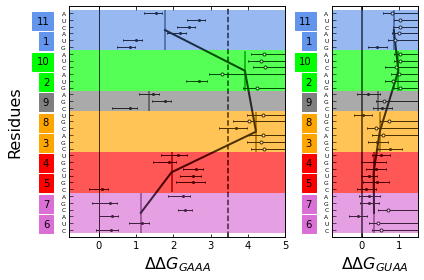

In [39]:
fig,axs = plt.subplots(figsize=(6,4),ncols=2,gridspec_kw={'width_ratios':[5.8,2.3]},facecolor='w')

markersize=2
capsize=1
avg_lw=2

temp_df = avg_ddG_GAAA_single_df.copy()
temp_df['first_loc'] = pd.Categorical(temp_df['first_loc'],[11,1,10,2,9,8,3,4,5,7,6],
                                     ordered=True)
temp_df = temp_df.sort_values(['first_loc','first_res'],ascending=False)

y_labels = temp_df['first_res'].values[::-1]

y_range = np.arange(len(temp_df))
x_vals = temp_df['ddG']
x_lb = x_vals - temp_df['ddG_lb']
x_ub = temp_df['ddG_ub'] - x_vals
limits = temp_df['limit']

axs[0].errorbar(x_vals[~limits],y_range[~limits],
            xerr=[x_lb[~limits],x_ub[~limits]],
            marker='o',lw=0,c='k',ms=markersize,
            ecolor='k',elinewidth=1,capsize=capsize)

axs[0].errorbar(x_vals[limits],y_range[limits],
            xerr=[x_lb[limits],[5]*sum(limits)],
            marker='o',lw=0,c='w',mec='k',ms=markersize+1,
            ecolor='k',elinewidth=1,capsize=capsize)

axs[0].axvline(np.mean(dG_GUAA_wt_df['dG'] - dG_GAAA_wt_df['dG']),color='k',linestyle='--')
axs[0].axvline(0,color='k',linestyle='-',linewidth=1)

#~~~~~~

temp_df = avg_ddG_GUAA_single_df.copy()
temp_df['first_loc'] = pd.Categorical(temp_df['first_loc'],[11,1,10,2,9,8,3,4,5,7,6],
                                     ordered=True)
temp_df = temp_df.sort_values(['first_loc','first_res'],ascending=False)

y_range = np.arange(len(temp_df))
x_vals = temp_df['ddG']
x_lb = x_vals - temp_df['ddG_lb']
x_ub = temp_df['ddG_ub'] - x_vals
limits = temp_df['limit']

axs[1].errorbar(x_vals[~limits],y_range[~limits],
            xerr=[x_lb[~limits],x_ub[~limits]],
            marker='o',lw=0,c='k',ms=markersize,
            ecolor='k',elinewidth=1,capsize=capsize)

axs[1].errorbar(x_vals[limits],y_range[limits],
            xerr=[x_lb[limits],[5]*sum(limits)],
            marker='o',lw=0,c='w',mec='k',ms=markersize+1,
            ecolor='k',elinewidth=1,capsize=capsize)

axs[1].axvline(0,color='k',linestyle='-')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


temp_df = avg_ddG_GAAA_single_df.copy()
temp_df['first_loc'] = pd.Categorical(temp_df['first_loc'],[11,1,10,2,9,8,3,4,5,7,6],
                                     ordered=True)
temp_df['base_step'] = temp_df['first_loc'].apply(lambda s: base_step[s])
mean_df = temp_df.groupby('base_step').agg(np.nanmean).sort_values(['base_step'])
std_df = temp_df.groupby('base_step').agg(np.nanstd).sort_values(['base_step'])

y_range = np.array([1,3,5,6.5,8,10])*3-.5
x_vals = mean_df['ddG']
x_lb = std_df['ddG']/np.sqrt(3)
x_ub = std_df['ddG']/np.sqrt(3)
limits = mean_df['limit']==1

axs[0].plot(np.delete(x_vals.values,3),np.delete(y_range,3),'-',color='k',linewidth=avg_lw)

axs[0].scatter(x_vals,y_range,c='k',marker='|',s=np.array([4,4,4,1,4,4])*400)

#~~~~~~

temp_df = avg_ddG_GUAA_single_df.copy()
temp_df['first_loc'] = pd.Categorical(temp_df['first_loc'],[11,1,10,2,9,8,3,4,5,7,6],
                                     ordered=True)
temp_df['base_step'] = temp_df['first_loc'].apply(lambda s: base_step[s])
mean_df = temp_df.groupby('base_step').agg(np.nanmean).sort_values(['base_step'])
std_df = temp_df.groupby('base_step').agg(np.nanstd).sort_values(['base_step'])

x_vals = mean_df['ddG']
x_lb = std_df['ddG']/np.sqrt(3)
x_ub = std_df['ddG']/np.sqrt(3)
limits = mean_df['limit']==1

axs[1].plot(np.delete(x_vals.values,3),np.delete(y_range,3),'-',color='k',linewidth=avg_lw)
axs[1].scatter(x_vals,y_range,c='k',marker='|',s=np.array([4,4,4,1,4,4])*400)


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


bar_colors = ['cornflowerblue','cornflowerblue','lime','lime','gray',
              'orange','orange','red','red','orchid','orchid'][::-1]

for ax in axs:
    ax.set_ylim((-1,33))
    ax.tick_params(left=True,top=True,direction='in')

    ax.set_yticks(np.arange(33))
    ax.set_yticklabels(y_labels[::-1],fontsize=6)

    for i,zipped in enumerate(zip(ax.get_yticklabels(),bar_colors)):
        label,c = zipped
        axs[0].axhspan(i*3-.5,(i+1)*3-.5,color=c,alpha=0.3,ec=None)
        axs[1].axhspan(i*3-.5,(i+1)*3-.5,color=c,alpha=0.3,ec=None)
        
for ax in axs:
    twin_ax = ax.twinx()
    twin_ax.set_yticks(np.arange(1,33,3))
    twin_ax.set_yticklabels([11,1,10,2,9,8,3,4,5,7,6][::-1])
    twin_ax.yaxis.set_tick_params(pad=20)
    twin_ax.set_ylim((-1,33))
    twin_ax.tick_params(right=False,labelleft=True,labelright=False,direction='in')

    for i,zipped in enumerate(zip(twin_ax.get_yticklabels(),bar_colors)):
        label,c = zipped
        twin_ax.axhspan(i*3-.5,(i+1)*3-.5,color=c,alpha=0.3,ec=None)
        label.set(bbox={'ec':c,'fc':c}) 


axs[0].set_ylabel('Residues\n\n',fontsize=16)
axs[1].set_xticks(range(0,6))
axs[0].set_xlim((-.8,5))
axs[1].set_xlim((-.8,1.5))


axs[0].set_xlabel('$\Delta\Delta G_{GAAA}$',fontsize=16)
axs[1].set_xlabel('$\Delta\Delta G_{GUAA}$',fontsize=16)

plt.tight_layout()

plt.savefig('Figures/Single_Mutant_Effects.svg',dpi=600)

plt.show()

## Base Pairing Interactions

In [40]:
WC_pairs =['AU','UA','GC','CG']
wobble_pairs = ['GU','UG']
RR_mismatches = ['AA','GG','AG','GA']
RY_mismatches = ['AC','CA']
YY_mismatches = ['UU','CC','UC','CU']
base_pairs = WC_pairs+wobble_pairs+RY_mismatches+RR_mismatches+YY_mismatches
base_pair_names = ['WC pair','Wobble pair','Mixed mismatch','RR mismatch','YY mismatch']
base_pair_colors=['tab:blue','tab:green','tab:olive','tab:red','tab:purple']

def assignBP(bases_s):
    out = pd.Series(index=bases_s.index,dtype=str)
    for bases in bases_s.iteritems():
        if bases[1] in WC_pairs:
            out.loc[bases[0]] = 'WC pair'
        elif bases[1] in wobble_pairs:
            out.loc[bases[0]] = 'Wobble pair'
        elif bases[1] in RR_mismatches:
            out.loc[bases[0]] = 'RR mismatch'
        elif bases[1] in RY_mismatches:
            out.loc[bases[0]] = 'Mixed mismatch'
        elif bases[1] in YY_mismatches:
            out.loc[bases[0]] = 'YY mismatch'
        else:
            out.loc[bases[0]] = np.NaN
    return out

In [41]:
ddG_GUAA_GAAA = np.mean(dG_GUAA_wt_df['dG'] - dG_GAAA_wt_df['dG'])
ddG_GUAA_GAAA

3.456523749239776

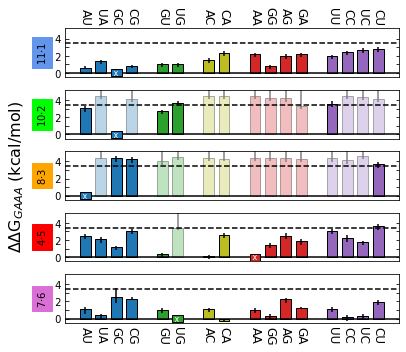

In [42]:
fig,axs = plt.subplots(nrows=5,figsize=(8,5),sharex=True,sharey=True,facecolor='w')

res1s = [11,10,8,4,7]
res2s = [1,2,3,5,6]

for res1,res2,ax,color in zip(res1s,res2s,axs,
                       ['cornflowerblue','lime','orange','red','orchid']):
    nuc1 = sequence_11ntRwt.replace('_','')[revDict(mutation_dict_11ntR)[res1]]
    nuc2 = sequence_11ntRwt.replace('_','')[revDict(mutation_dict_11ntR)[res2]]

    curr_data = pd.DataFrame({
                    f'{res1}_mut':nuc1,
                    f'{res2}_mut':nuc2,
                    'ddG':0,
                    'ddG_lb':0,
                    'ddG_ub':0,
                    'limit':False
                },index=[sequence_11ntRwt])

    temp_df = avg_ddG_GAAA_single_df.query(
        'first_loc == @res1').rename(
        columns={'first_res':f'{res1}_mut'})
    temp_df[f'{res2}_mut'] = nuc2
    curr_data = pd.concat((curr_data,temp_df))

    temp_df = avg_ddG_GAAA_single_df.query(
        'first_loc == @res2').rename(
        columns={'first_res':f'{res2}_mut'})
    temp_df[f'{res1}_mut'] = nuc1
    curr_data = pd.concat((curr_data,temp_df))

    temp_df = avg_ddG_GAAA_double_df.query(
        '(first_loc == @res1 & second_loc == @res2)').rename(
        columns={'first_res':f'{res1}_mut','second_res':f'{res2}_mut'})
    curr_data = pd.concat((curr_data,temp_df))

    temp_df = avg_ddG_GAAA_double_df.query(
        '(first_loc == @res2 & second_loc == @res1)').rename(
        columns={'first_res':f'{res2}_mut','second_res':f'{res1}_mut'})
    curr_data = pd.concat((curr_data,temp_df))
    
    curr_data['bases'] = curr_data[[f'{res1}_mut',f'{res2}_mut']].apply(lambda s: s[0]+s[1], axis=1)
    curr_data['bp'] = assignBP(curr_data['bases'])
    
    curr_data['bases'] = pd.Categorical(curr_data['bases'],base_pairs)
    
    x_offset = 0
    ax.axhline(0,color='k',linestyle='-')
    
    for bp,bp_color in zip(base_pair_names,base_pair_colors):
        plot_data = curr_data[curr_data['bp']==bp].sort_values('bases')
        
        x_range = np.arange(len(plot_data)) + x_offset + 2
        x_offset = x_range[-1]
        
        heights = plot_data['ddG']
        heights_ub = plot_data['ddG_ub'] - heights
        heights_ub[plot_data['limit']] = 10
        heights_lb = heights - plot_data['ddG_lb']
        
        bar_container = ax.bar(x_range,heights,label=bp,width=0.7,
               yerr=[heights_lb,heights_ub],ec='k',facecolor=bp_color)
        
        errorbar_colors=['k']*len(bar_container)
        for i,(limit,bar) in enumerate(zip(plot_data['limit'],
                                     bar_container.patches)):
            if limit:
                bar.set(alpha=0.3)
                errorbar_colors[i] = 'gray'
            elif bar.get_height() == 0:
                ax.text(*bar.get_xy(),' x',color='w',va='center',
                        zorder=20,fontsize=8)
                bar.set(height=.8,xy=np.array(bar.get_xy())+np.array([0,-0.4]),
                       zorder=10)
        bar_container.errorbar[2][0].set_colors(errorbar_colors)

    
    ax.set_ylim((-.5,5.2))
    
    ax.set_ylabel(f'{res1}$\cdot${res2}',bbox={'ec':color,'fc':color})
    ax.set_xlabel('')
    
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels([' 0','',' 2','',' 4'])
    ax.tick_params(bottom=False,right=True,direction='in')
    
    ax.axhline(ddG_GUAA_GAAA,color='k',linestyle='--')
        
    
ax.set_xticks(np.arange(20)+2)
ax.set_xticklabels(WC_pairs+['']+wobble_pairs+['']+RY_mismatches+['']+RR_mismatches+['']+YY_mismatches,
                  rotation=-90,fontsize=12)
axs[0].tick_params(axis="x", bottom=False, top=False, labelbottom=False, labeltop=True)
axs[0].set_xticklabels(WC_pairs+['']+wobble_pairs+['']+RY_mismatches+['']+RR_mismatches+['']+YY_mismatches,
                  rotation=-90,fontsize=12)
fig.supylabel(r'$\Delta\Delta$G$_{GAAA}$ (kcal/mol)',fontsize=16)

fig.tight_layout()
fig.subplots_adjust(right=0.7)
plt.savefig('Figures/GAAA_base_pair_effects.svg',dpi=600)
plt.show()


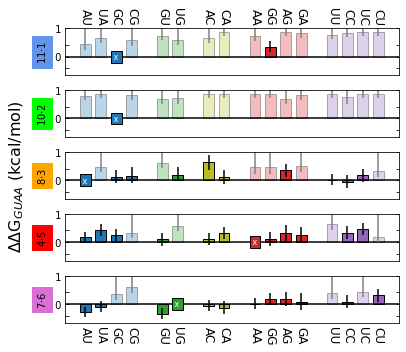

In [43]:
fig,axs = plt.subplots(nrows=5,figsize=(8,5),sharex=True,sharey=True,facecolor='w')

res1s = [11,10,8,4,7]
res2s = [1,2,3,5,6]

for res1,res2,ax,color in zip(res1s,res2s,axs,
                       ['cornflowerblue','lime','orange','red','orchid']):
    nuc1 = sequence_11ntRwt.replace('_','')[revDict(mutation_dict_11ntR)[res1]]
    nuc2 = sequence_11ntRwt.replace('_','')[revDict(mutation_dict_11ntR)[res2]]

    curr_data = pd.DataFrame({
                    f'{res1}_mut':nuc1,
                    f'{res2}_mut':nuc2,
                    'ddG':0,
                    'ddG_lb':0,
                    'ddG_ub':0,
                    'limit':False
                },index=[sequence_11ntRwt])

    temp_df = avg_ddG_GUAA_single_df.query(
        'first_loc == @res1').rename(
        columns={'first_res':f'{res1}_mut'})
    temp_df[f'{res2}_mut'] = nuc2
    curr_data = pd.concat((curr_data,temp_df))

    temp_df = avg_ddG_GUAA_single_df.query(
        'first_loc == @res2').rename(
        columns={'first_res':f'{res2}_mut'})
    temp_df[f'{res1}_mut'] = nuc1
    curr_data = pd.concat((curr_data,temp_df))

    temp_df = avg_ddG_GUAA_double_df.query(
        '(first_loc == @res1 & second_loc == @res2)').rename(
        columns={'first_res':f'{res1}_mut','second_res':f'{res2}_mut'})
    curr_data = pd.concat((curr_data,temp_df))

    temp_df = avg_ddG_GUAA_double_df.query(
        '(first_loc == @res2 & second_loc == @res1)').rename(
        columns={'first_res':f'{res2}_mut','second_res':f'{res1}_mut'})
    curr_data = pd.concat((curr_data,temp_df))
    
    curr_data['bases'] = curr_data[[f'{res1}_mut',f'{res2}_mut']].apply(lambda s: s[0]+s[1], axis=1)
    curr_data['bp'] = assignBP(curr_data['bases'])
    
    curr_data['bases'] = pd.Categorical(curr_data['bases'],base_pairs)
    
    
    x_offset = 0
    
    ax.axhline(0,color='k',linestyle='-')
    
    for bp,bp_color in zip(base_pair_names,base_pair_colors):
        plot_data = curr_data[curr_data['bp']==bp].sort_values('bases')
        
        x_range = np.arange(len(plot_data)) + x_offset + 2
        x_offset = x_range[-1]
        
        heights = plot_data['ddG']
        heights_ub = plot_data['ddG_ub'] - heights
        heights_ub[plot_data['limit']] = 10
        heights_lb = heights - plot_data['ddG_lb']
        
        bar_container = ax.bar(x_range,heights,label=bp,width=0.7,
               yerr=[heights_lb,heights_ub],ec='k',facecolor=bp_color)
        
        errorbar_colors=['k']*len(bar_container)
        for i,(limit,bar) in enumerate(zip(plot_data['limit'],
                                     bar_container.patches)):
            if limit:
                bar.set(alpha=0.3)
                errorbar_colors[i] = 'gray'
            elif bar.get_height() == 0:
                ax.text(*bar.get_xy(),' x',color='w',va='center',
                        zorder=20,fontsize=8)
                bar.set(height=.5,xy=np.array(bar.get_xy())+np.array([0,-0.25]),
                       zorder=10)
        bar_container.errorbar[2][0].set_colors(errorbar_colors)

    
    ax.set_ylim((-.8,1))
    
    ax.set_ylabel(f'{res1}$\cdot${res2}',bbox={'ec':color,'fc':color})
    ax.set_xlabel('')
    
    ax.set_yticks([-.5,0,.5,1.2])
    ax.set_yticklabels(['',' 0','',' 1'])
    ax.tick_params(bottom=False,right=True,direction='in')
    
        
    
ax.set_xticks(np.arange(20)+2)
ax.set_xticklabels(WC_pairs+['']+wobble_pairs+['']+RY_mismatches+['']+RR_mismatches+['']+YY_mismatches,
                  rotation=-90,fontsize=12)
axs[0].tick_params(axis="x", bottom=False, top=False, labelbottom=False, labeltop=True)
axs[0].set_xticklabels(WC_pairs+['']+wobble_pairs+['']+RY_mismatches+['']+RR_mismatches+['']+YY_mismatches,
                  rotation=-90,fontsize=12)
fig.supylabel(r'$\Delta\Delta$G$_{GUAA}$ (kcal/mol)',fontsize=16)


fig.tight_layout()
fig.subplots_adjust(right=0.7)
plt.savefig('Figures/GUAA_base_pair_effects.svg',dpi=600)
plt.show()


## Cooperativity

In [44]:
def getCooperativityDF(meta,single_bs_df,double_bs_df,
                       wt_bs_df,avg_single_dG_df,
                       single_dG_df,double_dG_df):
    '''average scaffolds, get p values for the following 3 tests:
        1: double > sum single  
            yes: greater; no: goto 2
        2: sum single > double
            yes: goto 3; no: additive
        3: single 1 (larger) > double
            yes: rescue; no: cooperative (partial)
        '''
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    wt = wt_bs_df.reset_index(level='seq',drop=True)[bs_cols]
    
    out_df = meta.copy()
    
    for seq in tqdm(meta.index):
        
        # assign dG1 and dG2
        loc_res_1 = list(meta.loc[seq,['first_loc','first_res']])
        loc_res_2 = list(meta.loc[seq,['second_loc','second_res']])
        
        df1 = avg_single_dG_df[\
                            (avg_single_dG_df['first_loc']==loc_res_1[0])&\
                            (avg_single_dG_df['first_res']==loc_res_1[1])]
        df2 = avg_single_dG_df[\
                            (avg_single_dG_df['first_loc']==loc_res_2[0])&\
                            (avg_single_dG_df['first_res']==loc_res_2[1])]
        
        singles_arr = [[df1.index,df2.index],
                       [df1['dG'][0],df2['dG'][0]]]
        
        dG1_seq = singles_arr[0][np.argmax(singles_arr[1])]
        dG2_seq = singles_arr[0][np.argmin(singles_arr[1])]
        
        # Acrue bootstrap data
        D = double_bs_df.loc[(seq,slice(None)),bs_cols].reset_index(
                level='seq',drop=True)-wt
        S1 = single_bs_df.loc[(dG1_seq,slice(None)),bs_cols].reset_index(
                level='seq',drop=True)[bs_cols]-wt
        S2 = single_bs_df.loc[(dG2_seq,slice(None)),bs_cols].reset_index(
                level='seq',drop=True)[bs_cols]-wt
        SS = np.add(S1,S2)
        
        S1 = S1[~SS.isna()]
        D = D[~SS.isna()]
        
        # Calculate pvals for relevant tests        
        DmSS = np.nanmean(D-SS,axis=0)
        SSmD = np.nanmean(SS-D,axis=0)
        S1mD = np.nanmean(S1-D,axis=0)
        S2_zero = np.nanmean(S2,axis=0)
        
        # Store pvals
        for name,p in zip(['p_G','p_C','p_R','p_S2'],[DmSS,SSmD,S1mD,S2_zero]):
            if ~np.isnan(p[0]):
                out_df.loc[seq,name] = (sum(p <= 0))/10000
            else:
                out_df.loc[seq,name] = np.NaN
        
        # Store relevant ddGs
        for name,df in zip(['dddG','D','S1','S2','SS'],[SS-D,D,S1,S2,SS]):
            ps = pd.DataFrame(np.nanmean(df,axis=0)).quantile(
                q=[0.5,0.025,0.975],axis=0).T.rename(
                     columns={k:v for k,v in zip([0.5,0.025,0.975],
                                                 ['ddG','lb','ub'])})
            for col in ps.columns:
                out_df.loc[seq,'_'.join([name,col])] = ps[col].values
    
    return out_df
            
    

In [45]:
def coopType(df,pG,pC,pR,alpha):
    '''returns cooperativity type given p values for aforementioned tests
       ~~ todo: better treatment of double mutant limits (could be greater)
                and of sum single limit(could be cooperative if double is not limit)'''
    if pR:
        if np.isnan(sum(df[[pG,pC,pR]])):
            return 'L'
    else:
        if np.isnan(sum(df[[pG,pC]])):
            return 'L'
    
    if df[pG] >= alpha:
        if df[pC] >= alpha:
            return 'A'
        if pR:
            if df[pR] >= alpha:
                return 'C'
        else:
            return 'C'
        return 'R'
    else:
        return 'G'

In [46]:
# GAAA_coop_df = getCooperativityDF(double_meta_df.groupby('seq').first(),
#                                   replaceLimits(
#                                       GAAA_single_bs_df,
#                                       limits=dG_GAAA_single_df['limit']
#                                   ),
#                                   replaceLimits(
#                                       GAAA_double_bs_df,
#                                       limits=dG_GAAA_double_df['limit']
#                                   ),
#                                   GAAA_wt_bs_df,
#                                   avg_dG_GAAA_single_df,
#                                   dG_GAAA_single_df,
#                                   dG_GAAA_double_df)

In [47]:
# GAAA_all_pvals = GAAA_coop_df[['p_G','p_C','p_R','p_S2']].values.flatten()

# GAAA_corr_pvals = GAAA_all_pvals.copy()
# _,GAAA_corr_pvals[~np.isnan(GAAA_corr_pvals)],_,_ = multitest.multipletests(
#     GAAA_corr_pvals[~np.isnan(GAAA_corr_pvals)],method='fdr_bh')

# GAAA_corr_pvals = np.reshape(GAAA_corr_pvals,(-1,4))

In [48]:
# GAAA_coop_df['adj_p_G'] = GAAA_corr_pvals[:,0]
# GAAA_coop_df['adj_p_C'] = GAAA_corr_pvals[:,1]
# GAAA_coop_df['adj_p_R'] = GAAA_corr_pvals[:,2]
# GAAA_coop_df['adj_p_S2'] = GAAA_corr_pvals[:,3]

In [49]:
# for idx in GAAA_coop_df.index:
#     GAAA_coop_df.loc[idx,'coop'] = coopType(GAAA_coop_df.loc[idx,:],
#                                             'adj_p_G','adj_p_C','adj_p_R',0.05)

In [50]:
# GAAA_coop_df.to_pickle(data_path+'GAAA_coop_df.pkl')

In [51]:
GAAA_coop_df = pd.read_pickle(data_path+'GAAA_coop_df.pkl')

In [52]:
plot_coop_order = ['S2','S1','SS','D']
nucSortFun = lambda S: [{'A':1,'U':2,'G':3,'C':4}[s] for s in S]
coop_colors = {
    'L':'tab:gray',
    'A':'tab:blue',
    'C':'tab:red',
    'G':'tab:green',
    'R':'tab:orange'
}


In [53]:
GAAA_coop_df.loc[(GAAA_coop_df['D_ub']>=GAAA_ddG_limit) &\
                 (GAAA_coop_df['coop']!='G'),'coop'] = 'L'

In [54]:
GAAA_coop_df.query('(S1_ub >= @GAAA_ddG_limit | S2_ub >= @GAAA_ddG_limit)')['coop'].value_counts()

L    155
R     35
C      7
A      3
Name: coop, dtype: int64

In [55]:
GAAA_coop_df.loc[(GAAA_coop_df['S1_ub']>=GAAA_ddG_limit) &\
                 (GAAA_coop_df['coop']=='A'),'coop'] = 'L'

In [56]:
GAAA_coop_df['coop'].value_counts()

L    231
A     99
R     68
C     63
G     34
Name: coop, dtype: int64

In [57]:
for s in ['dddG','D','SS','S1']:
    GAAA_coop_df[s] = GAAA_coop_df.apply(lambda x:f"{x[s+'_ddG']:.2f} ({x[s+'_lb']:.2f},{x[s+'_ub']:.2f})",axis=1)
GAAA_coop_df

,first_loc,first_res,second_loc,second_res,p_G,p_C,p_R,p_S2,dddG_ddG,dddG_lb,...,SS_ub,adj_p_G,adj_p_C,adj_p_R,adj_p_S2,coop,dddG,D,SS,S1
seq,,,,,,,,,,,,,,,,,,,,,
AAAGG_CCUAAG,7,A,9,A,0.9912,0.0088,1.0000,0.0000,0.590475,0.115284,...,4.123412,1.0,0.022310,1.000000,0.000,C,"0.59 (0.12,0.90)","3.16 (2.70,3.43)","3.78 (2.94,4.12)","2.27 (1.85,2.44)"
AACGG_CCUAAG,7,A,9,C,0.8535,0.1465,0.9999,0.0011,0.307398,-0.329499,...,3.445151,1.0,0.294189,1.000000,0.003,A,"0.31 (-0.33,0.64)","2.75 (2.30,3.06)","3.08 (2.16,3.45)","2.27 (1.85,2.44)"
AAGGG_CCUAAG,7,A,9,G,0.9479,0.0521,1.0000,0.0000,0.365053,-0.086891,...,4.390849,1.0,0.115132,1.000000,0.000,A,"0.37 (-0.09,0.64)","3.68 (3.23,3.92)","4.07 (3.23,4.39)","2.27 (1.85,2.44)"
AAUAG_CCUAAG,7,A,10,A,1.0000,0.0000,0.7287,0.0000,2.218077,1.774437,...,7.245504,1.0,0.000000,1.000000,0.000,L,"2.22 (1.77,2.46)","4.67 (4.25,4.82)","6.89 (6.05,7.25)","4.61 (4.18,4.83)"
AAUCG_CCUAAG,7,A,10,C,1.0000,0.0000,0.5528,0.0000,2.249358,1.820838,...,7.245330,1.0,0.000000,0.951777,0.000,L,"2.25 (1.82,2.48)","4.66 (4.22,4.84)","6.92 (6.08,7.25)","4.65 (4.22,4.83)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UUUGG_CUUAAG,8,U,2,U,1.0000,0.0000,0.9741,0.0000,2.632885,2.184705,...,7.484244,1.0,0.000000,1.000000,0.000,L,"2.63 (2.18,2.88)","4.50 (4.08,4.64)","7.13 (6.28,7.48)","4.40 (3.97,4.58)"
UUUGG_GCUAAG,8,U,1,G,0.9992,0.0008,0.9741,0.0000,0.759844,0.329102,...,5.566663,1.0,0.002269,1.000000,0.000,L,"0.76 (0.33,0.95)","4.50 (4.08,4.64)","5.26 (4.42,5.57)","4.40 (3.97,4.58)"
UUUGG_UCUAAG,8,U,1,U,0.9999,0.0001,0.9741,0.0000,0.903827,0.461830,...,5.738588,1.0,0.000294,1.000000,0.000,L,"0.90 (0.46,1.13)","4.50 (4.08,4.64)","5.40 (4.57,5.74)","4.40 (3.97,4.58)"


In [58]:
out_df = GAAA_coop_df[['first_loc','first_res','second_loc','second_res','coop','dddG','D','SS','S1','adj_p_G','adj_p_C','adj_p_R']]
out_df.loc[:,'coop'] = out_df['coop'].apply(lambda s: {'G':'S','C':'C','R':'R','A':'A','L':'L'}[s])


out_df.to_csv('Figures/GAAA_coop.csv')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [59]:
coop_types = ['L','G','A','C','R'] # limits, greater, additive, cooperative, rescue

In [60]:
def fillHeatmap(df):
    
    colnames = df.columns.names
    indexcolumns = set(df.index)|set(df.columns)
    df[list(indexcolumns-set(df.columns))]=np.NaN
    df = pd.concat([df,pd.DataFrame(index=list(indexcolumns-set(df.index)))])
    df.columns.names = colnames
    
    return df

In [61]:
dddG_df = pd.pivot_table(GAAA_coop_df,columns=['second_loc','second_res'],index=['first_loc','first_res'],values='dddG_ddG')
dddG_df = fillHeatmap(dddG_df)
dddG_df = dddG_df.sort_values(by=['second_loc','second_res'],axis=1).sort_values('first_loc',axis=0)
dddG_df = dddG_df.fillna(0) + dddG_df.fillna(0).values.T
dddG_df = dddG_df.replace(0,np.NaN)


In [62]:
coop_type_df = pd.pivot_table(GAAA_coop_df,columns=['second_loc','second_res'],index=['first_loc','first_res'],values='coop',
                      aggfunc=lambda s:s)
coop_type_df = fillHeatmap(coop_type_df)
coop_type_df = coop_type_df.sort_values(by=['second_loc','second_res'],axis=1).sort_values('first_loc',axis=0)


In [63]:
for row in coop_type_df.iterrows():
    for col in row[1].iteritems():
        if pd.isna(col[1]):
            coop_type_df.loc[row[0],col[0]] = coop_type_df.loc[col[0],row[0]]

In [64]:
masku = np.triu(np.ones_like(np.zeros((11*3,11*3)), dtype=bool))
maskl = np.tril(np.ones_like(np.zeros((11*3,11*3)), dtype=bool))

__Supplemental Figure__

In [65]:
# fig,ax = plt.subplots(facecolor='w',figsize=(10,6))


# axis_labels = (dddG_df.loc[[11,1,10,2,9,8,3,4,5,7,6],[11,1,10,2,9,8,3,4,5,7,6]].index)


# sns.heatmap(coop_type_df.loc[[11,1,10,2,9,8,3,4,5,7,6],[11,1,10,2,9,8,3,4,5,7,6]].replace(
#                                         {k:v for v,k in enumerate(coop_types)}),
#             ax=ax,square=True,
#             vmin=-.5,vmax=4.5,
#             linewidths=.5,cmap=['grey','tab:green','tab:blue','tab:red','tab:orange'],mask=masku,
#             cbar_kws={'ticks':[0,1,2,3,4]})   
# sns.heatmap(dddG_df.loc[[11,1,10,2,9,8,3,4,5,7,6],[11,1,10,2,9,8,3,4,5,7,6]],
#             ax=ax,square=True,
#             linewidths=.5,mask=maskl,cmap='bwr_r',center=0)   
# ax.collections[0].colorbar.set_ticklabels(['Limit','Synergistic','Additive','Cooperative','Rescue'],
#                                          rotation=-45,fontsize=12,va='top')

# ax.collections[1].colorbar.set_label(r'$\Delta\Delta\Delta$G (kcal/mol)',fontsize=14,rotation=-90)

# ax.hlines(np.array([2,4,5,7,9])*3,*ax.get_xlim(),'k',linestyle='dashed')
# ax.vlines(np.array([2,4,5,7,9])*3,*ax.get_ylim(),'k',linestyle='dashed')
# ax.hlines(np.array([1,3,6,8])*3,*ax.get_xlim(),'k')
# ax.vlines(np.array([1,3,6,8])*3,*ax.get_ylim(),'k')

# ax.set_yticks(np.arange(33))
# ax.set_xticks(np.arange(33))


# ax.set_yticklabels(['-'.join([str(s) for s in idx]) for idx in axis_labels],fontsize=8)
# ax.set_xticklabels(['-'.join([str(s) for s in idx]) for idx in axis_labels],fontsize=8)

# ax.set_ylabel('First Mutant',fontsize=16)
# ax.set_xlabel('Second Mutant',fontsize=16)
# plt.savefig('Figures/Supplement/cooperativity_heatmap.png',dpi=600,facecolor='w')


# plt.show()

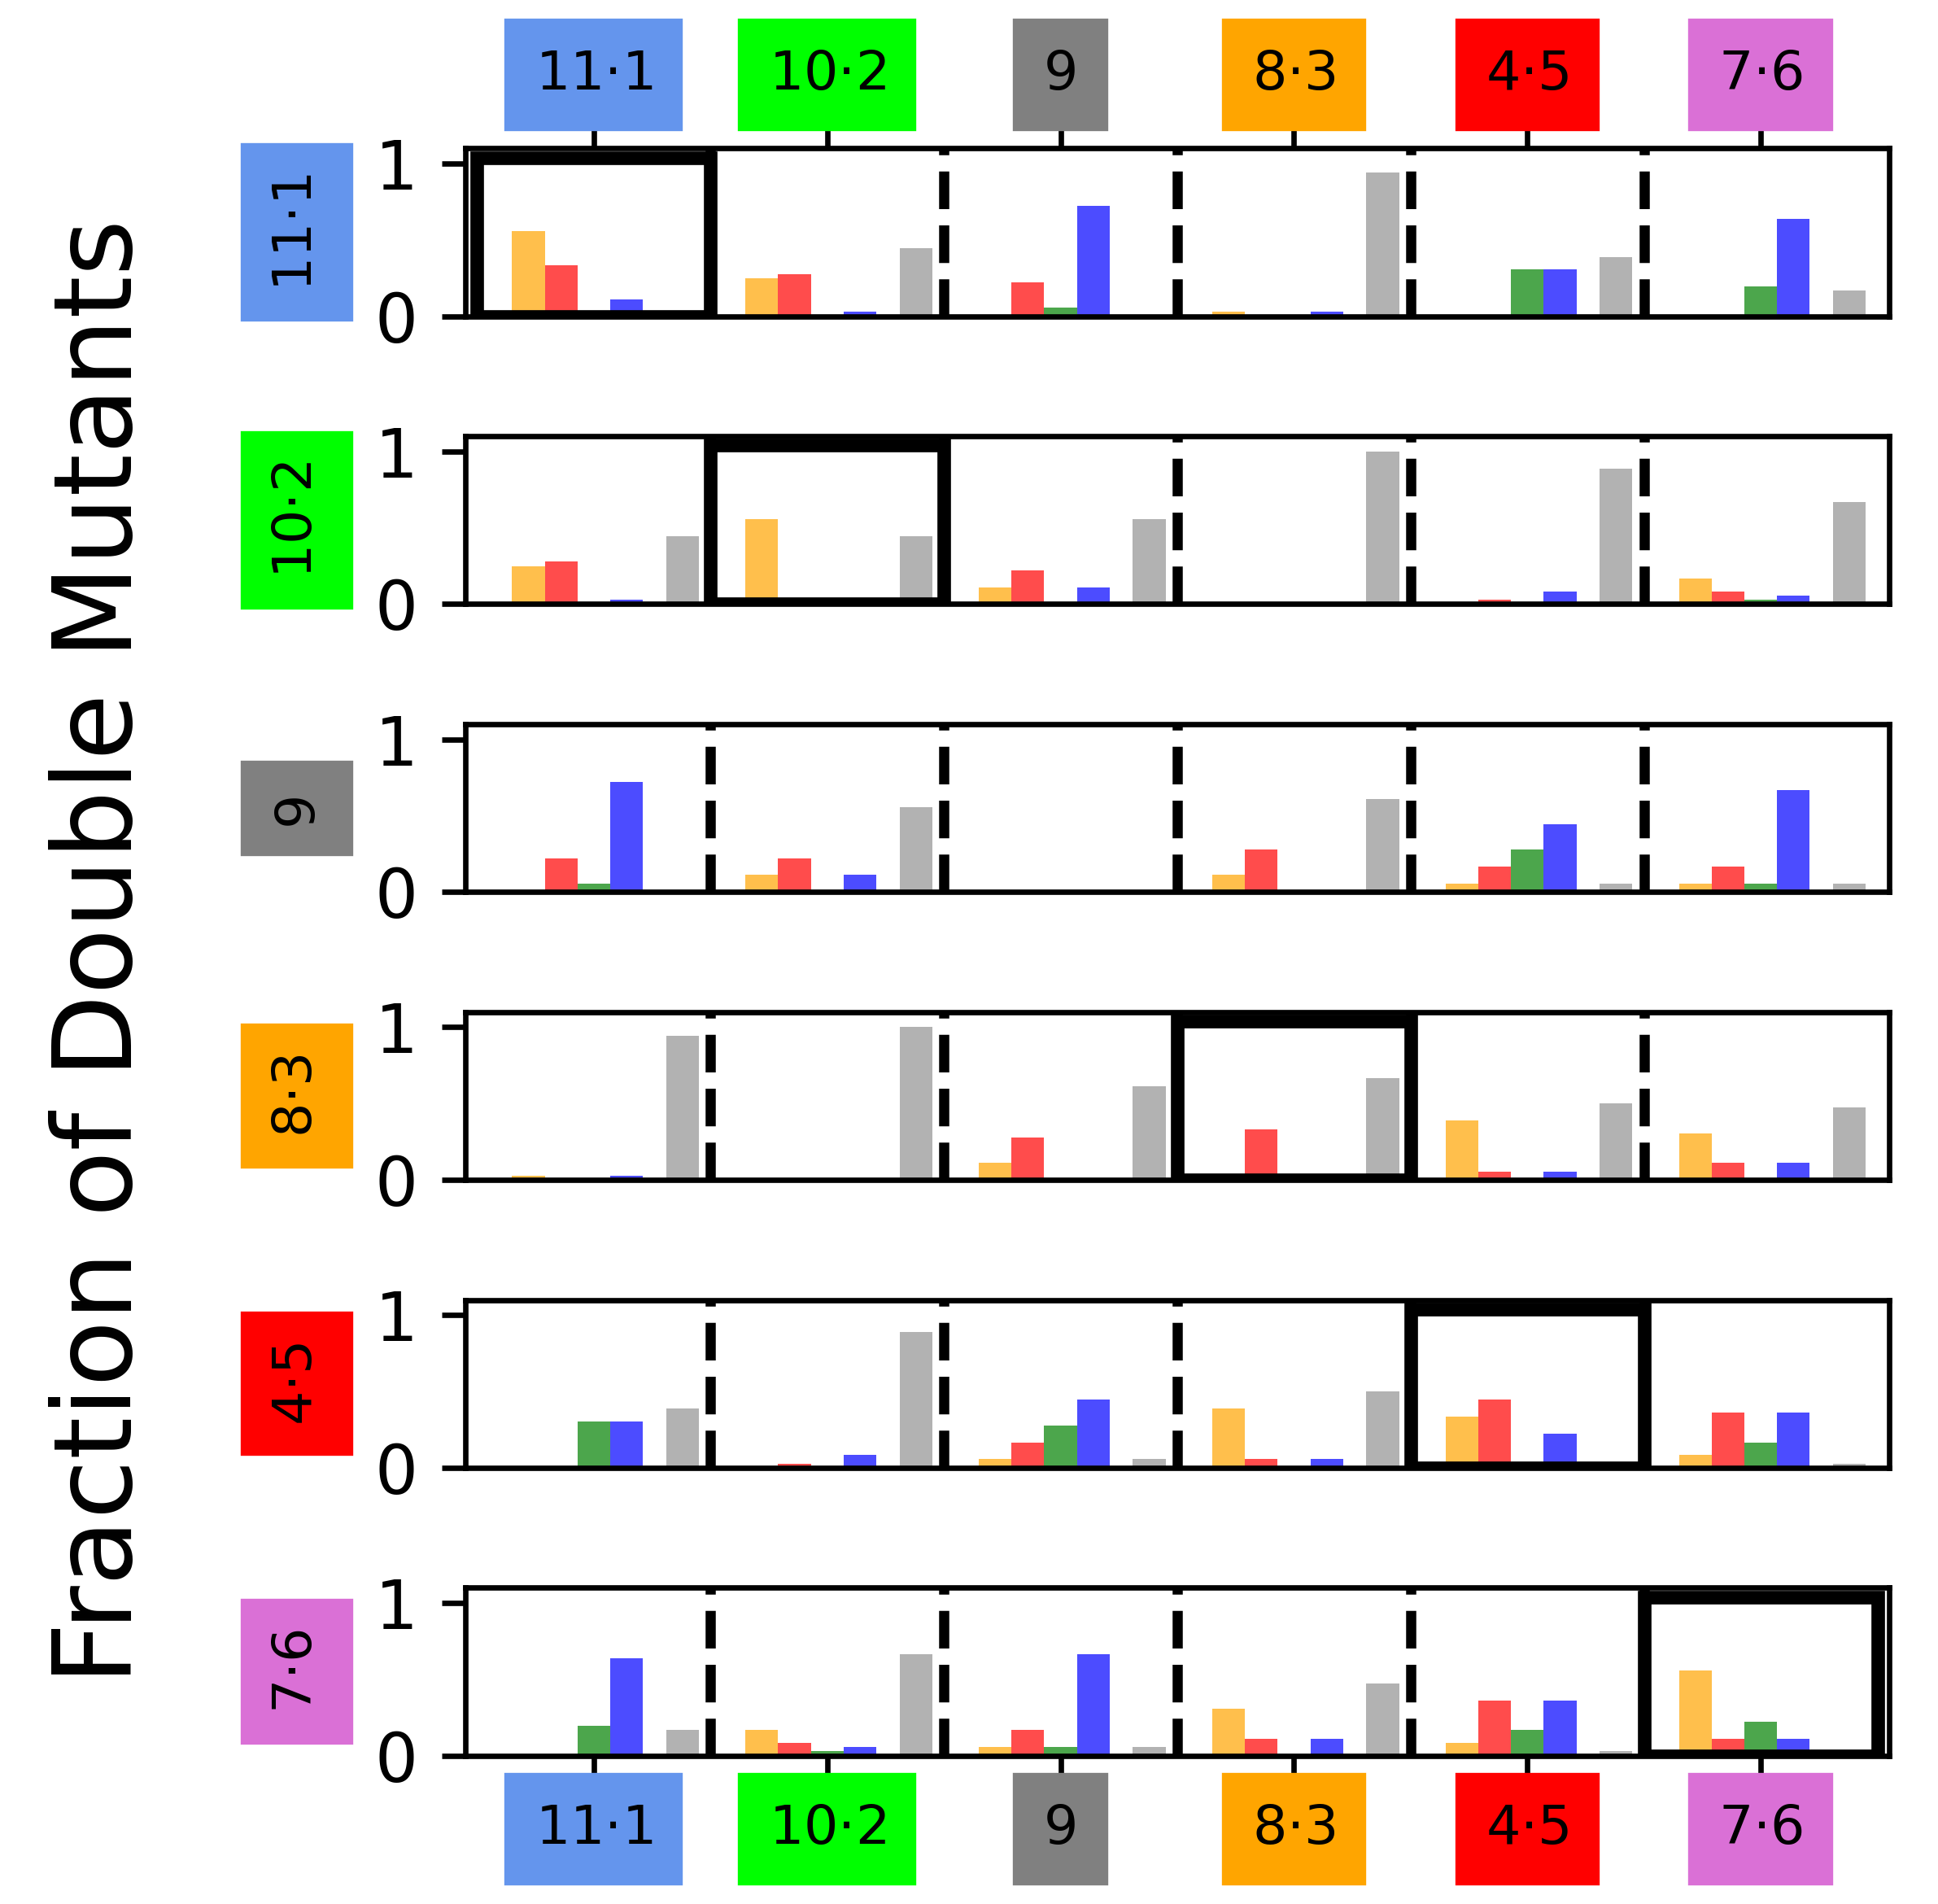

In [121]:
fig,axes = plt.subplots(nrows=6,ncols=1,figsize=(4,4),facecolor='w',sharex=True,sharey=True,dpi=600)

bps = [[11,1],[10,2],[9,0],[8,3],[4,5],[7,6]]
bp_dict = {11:r'11$\cdot$1',
         1:r'11$\cdot$1',
         10:r'10$\cdot$2',
         2:r'10$\cdot$2',
         9:r'9',
         8:r'8$\cdot$3',
         3:r'8$\cdot$3',
         4:r'4$\cdot$5',
         5:r'4$\cdot$5',
         7:r'7$\cdot$6',
         6:r'7$\cdot$6'}
bp_list = [r'11$\cdot$1',r'10$\cdot$2',r'9',r'8$\cdot$3',r'4$\cdot$5',r'7$\cdot$6']

for offset,(bp,ax,color) in enumerate(zip(bps,axes,
                       ['cornflowerblue','lime','gray','orange','red','orchid'])):
    
    
    loc1,loc2 = bp
    
    curr_data = GAAA_coop_df.query(
                   ('(((first_loc==@loc1))|'
                    '((first_loc==@loc2)))'))
    curr_data = curr_data.replace(
        {'first_loc':bp_dict,'second_loc':bp_dict}).rename(
        columns={'first_loc':'first_bp','second_loc':'second_bp'})
    
    temp_data =  GAAA_coop_df.query(
                    ('(((second_loc==@loc1))|'
                     '((second_loc==@loc2)))'))
    temp_data = temp_data.replace(
        {'second_loc':bp_dict,'first_loc':bp_dict}).rename(
        columns={'second_loc':'first_bp','first_loc':'second_bp'})
    
    curr_data = pd.concat([curr_data,temp_data])
    
    
    pivot_data = curr_data[['second_bp','coop']].pivot_table(
        index='second_bp',columns=['coop'],aggfunc=len)
    
    pivot_data[list(set(('L','G','A','C','R')) - set(pivot_data.columns))] = np.NaN
    pivot_data.loc[list(set(('L','G','A','C','R')) - set(pivot_data.columns))] = np.NaN
    pivot_data = pd.concat((pivot_data,pd.DataFrame(index=list(set(bp_list)-set(pivot_data.index)))))
    
    bar_container = pivot_data.loc[bp_list,['R','C','G','A','L']].apply(
        lambda s:s/np.nansum(s),axis=1).plot(
        kind='bar',color=['orange','red','green','blue','gray'],alpha=0.7,
        legend=False,ax=ax,width=.7)
    
    bar_groups = bar_container.containers
    
    for bar in bar_groups[-1]:
        x_pos = bar.get_x()
        bar.set_x(x_pos+.1)
        bar.set_alpha(0.6)
    
    ax.tick_params(labelbottom=False,bottom=False)
    ax.set_xlabel('')
    
    ax.set_ylabel(bp_dict[bp[0]],bbox={'ec':color,'fc':color},fontsize=8)
    if offset != 2:
        ax.add_patch(mpatches.Rectangle((offset-.5,0),1,1.04,fill=False,
                                        edgecolor='k',linewidth=2,zorder=np.inf))
#         ax.add_patch(mpatches.Rectangle((offset+1-.3,0),.6,1.04,fill=False,
#                                         edgecolor='gray',linewidth=2,zorder=np.inf))
#         ax.add_patch(mpatches.Rectangle((offset-1-.3,0),.6,1.04,fill=False,
#                                         edgecolor='gray',linewidth=2,zorder=np.inf))
    ax.yaxis.set_label_coords(-0.1,0.5)

    ax.set_ylim((0,1.1))
    
    ax.vlines(np.arange(5)+0.5,*ax.get_ylim(),color='k',linestyle='--')

    
ax.tick_params(labelbottom=True,bottom=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=8)

ax.set_xlim(-0.55,5.55)

axes[0].tick_params(labeltop=True,top=True)
axes[0].set_xticklabels(ax.get_xticklabels(),rotation=0,fontsize=8)

for l1,l2,color in zip(ax.xaxis.get_ticklabels(),
                       axes[0].xaxis.get_ticklabels(),
                       ['cornflowerblue','lime','gray','orange','red','orchid']):
    l1.set_bbox({'ec':color,'fc':color})
    l2.set_bbox({'ec':color,'fc':color})



fig.supylabel('Fraction of Double Mutants',fontsize=16)

plt.tight_layout()
# plt.savefig('Figures/cooperativity_fractions.svg',dpi=600)

plt.show()


In [107]:
bar_groups

[<BarContainer object of 6 artists>,
 <BarContainer object of 6 artists>,
 <BarContainer object of 6 artists>,
 <BarContainer object of 6 artists>,
 <BarContainer object of 6 artists>]

In [114]:
for i,bar_group in enumerate(bar_groups):
    for j,bar in enumerate(bar_group):
        print(i,j,bar.get_facecolor())

0 0 (1.0, 0.6470588235294118, 0.0, 0.7)
0 1 (1.0, 0.6470588235294118, 0.0, 0.7)
0 2 (1.0, 0.6470588235294118, 0.0, 0.7)
0 3 (1.0, 0.6470588235294118, 0.0, 0.7)
0 4 (1.0, 0.6470588235294118, 0.0, 0.7)
0 5 (1.0, 0.6470588235294118, 0.0, 0.7)
1 0 (1.0, 0.0, 0.0, 0.7)
1 1 (1.0, 0.0, 0.0, 0.7)
1 2 (1.0, 0.0, 0.0, 0.7)
1 3 (1.0, 0.0, 0.0, 0.7)
1 4 (1.0, 0.0, 0.0, 0.7)
1 5 (1.0, 0.0, 0.0, 0.7)
2 0 (0.0, 0.5019607843137255, 0.0, 0.7)
2 1 (0.0, 0.5019607843137255, 0.0, 0.7)
2 2 (0.0, 0.5019607843137255, 0.0, 0.7)
2 3 (0.0, 0.5019607843137255, 0.0, 0.7)
2 4 (0.0, 0.5019607843137255, 0.0, 0.7)
2 5 (0.0, 0.5019607843137255, 0.0, 0.7)
3 0 (0.0, 0.0, 1.0, 0.7)
3 1 (0.0, 0.0, 1.0, 0.7)
3 2 (0.0, 0.0, 1.0, 0.7)
3 3 (0.0, 0.0, 1.0, 0.7)
3 4 (0.0, 0.0, 1.0, 0.7)
3 5 (0.0, 0.0, 1.0, 0.7)
4 0 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.7)
4 1 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.7)
4 2 (0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.7)
4 3 (0.501

In [67]:
base_steps = {
    1:1,
    11:1,
    2:2,
    10:2,
    9:3,
    3:4,
    8:4,
    4:5,
    5:5,
    6:6,
    7:6    
}

In [68]:
GAAA_coop_df['first_base_step'] = GAAA_coop_df['first_loc'].apply(lambda s:base_steps[s])
GAAA_coop_df['second_base_step'] = GAAA_coop_df['second_loc'].apply(lambda s:base_steps[s])
GAAA_coop_df['base_step_dist'] = np.abs(GAAA_coop_df['first_base_step']-GAAA_coop_df['second_base_step'])
GAAA_coop_df

,first_loc,first_res,second_loc,second_res,p_G,p_C,p_R,p_S2,dddG_ddG,dddG_lb,...,adj_p_R,adj_p_S2,coop,dddG,D,SS,S1,first_base_step,second_base_step,base_step_dist
seq,,,,,,,,,,,,,,,,,,,,,
AAAGG_CCUAAG,7,A,9,A,0.9912,0.0088,1.0000,0.0000,0.590475,0.115284,...,1.000000,0.000,C,"0.59 (0.12,0.90)","3.16 (2.70,3.43)","3.78 (2.94,4.12)","2.27 (1.85,2.44)",6,3,3
AACGG_CCUAAG,7,A,9,C,0.8535,0.1465,0.9999,0.0011,0.307398,-0.329499,...,1.000000,0.003,A,"0.31 (-0.33,0.64)","2.75 (2.30,3.06)","3.08 (2.16,3.45)","2.27 (1.85,2.44)",6,3,3
AAGGG_CCUAAG,7,A,9,G,0.9479,0.0521,1.0000,0.0000,0.365053,-0.086891,...,1.000000,0.000,A,"0.37 (-0.09,0.64)","3.68 (3.23,3.92)","4.07 (3.23,4.39)","2.27 (1.85,2.44)",6,3,3
AAUAG_CCUAAG,7,A,10,A,1.0000,0.0000,0.7287,0.0000,2.218077,1.774437,...,1.000000,0.000,L,"2.22 (1.77,2.46)","4.67 (4.25,4.82)","6.89 (6.05,7.25)","4.61 (4.18,4.83)",6,2,4
AAUCG_CCUAAG,7,A,10,C,1.0000,0.0000,0.5528,0.0000,2.249358,1.820838,...,0.951777,0.000,L,"2.25 (1.82,2.48)","4.66 (4.22,4.84)","6.92 (6.08,7.25)","4.65 (4.22,4.83)",6,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UUUGG_CUUAAG,8,U,2,U,1.0000,0.0000,0.9741,0.0000,2.632885,2.184705,...,1.000000,0.000,L,"2.63 (2.18,2.88)","4.50 (4.08,4.64)","7.13 (6.28,7.48)","4.40 (3.97,4.58)",4,2,2
UUUGG_GCUAAG,8,U,1,G,0.9992,0.0008,0.9741,0.0000,0.759844,0.329102,...,1.000000,0.000,L,"0.76 (0.33,0.95)","4.50 (4.08,4.64)","5.26 (4.42,5.57)","4.40 (3.97,4.58)",4,1,3
UUUGG_UCUAAG,8,U,1,U,0.9999,0.0001,0.9741,0.0000,0.903827,0.461830,...,1.000000,0.000,L,"0.90 (0.46,1.13)","4.50 (4.08,4.64)","5.40 (4.57,5.74)","4.40 (3.97,4.58)",4,1,3


In [69]:
coop_by_dist = GAAA_coop_df[['base_step_dist','coop']].query('coop != "L"').reset_index().pivot_table(
                        index='base_step_dist',columns='coop',values=['seq'],aggfunc='count').fillna(0)
normed_coop_by_dist = coop_by_dist.apply(lambda s:s/coop_by_dist.sum(axis=1))
normed_coop_by_dist

seq                              
coop                   A         C         G         R
base_step_dist                                        
0               0.114286  0.314286  0.057143  0.514286
1               0.204545  0.386364  0.068182  0.340909
2               0.462963  0.203704  0.111111  0.222222
3               0.695652  0.173913  0.043478  0.086957
4               0.382353  0.088235  0.352941  0.176471
5               0.766667  0.000000  0.233333  0.000000

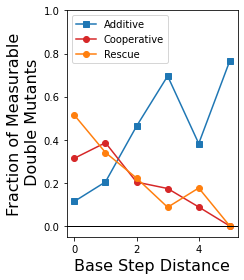

In [70]:
fig,ax = plt.subplots(figsize=(3.5,4))

ax.plot(np.arange(6),normed_coop_by_dist[('seq','A')],'s-',color='tab:blue',label='Additive')
ax.plot(np.arange(6),normed_coop_by_dist[('seq','C')],'o-',color='tab:red',label='Cooperative')
ax.plot(np.arange(6),normed_coop_by_dist[('seq','R')],'o-',color='tab:orange',label='Rescue')
    
ax.set_ylim((-0.05,1))
ax.axhline(0,color='k',linewidth=1)
ax.legend(fontsize=10,loc='upper left')
ax.set_ylabel('Fraction of Measurable\n Double Mutants',fontsize=16)
ax.set_xlabel('Base Step Distance',fontsize=16)

plt.tight_layout()

plt.savefig('Figures/Coop_vs_dist.svg',facecolor='white',dpi=600)
plt.show()